In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [143]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self - other
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}i') 
        
        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * (other**-1)
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return(out)
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad +=  out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label = 'e'
# d = a*b + c
# d = a.__mul__(b).__add__(c)
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = "L"

L

Value(data=-8.0)

In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % ( n.label, n.data, n.grad ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [4]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [5]:
o.backward()

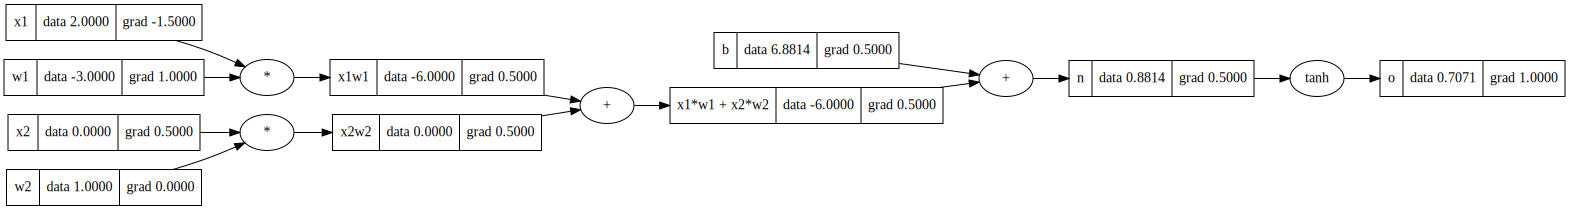

In [6]:
draw_dot(o)

In [7]:
a = Value(2.0)
a + 1

Value(data=3.0)

In [8]:
a * 1

Value(data=2.0)

In [9]:
1 * a

Value(data=2.0)

In [10]:
a.exp()

Value(data=7.38905609893065)

In [11]:
a.backward()

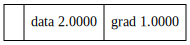

In [12]:
draw_dot(a)

In [13]:
a = Value(2.0)
b = Value(4.0)

In [14]:
a / b

Value(data=0.5)

In [15]:
a - b

Value(data=-2.0)

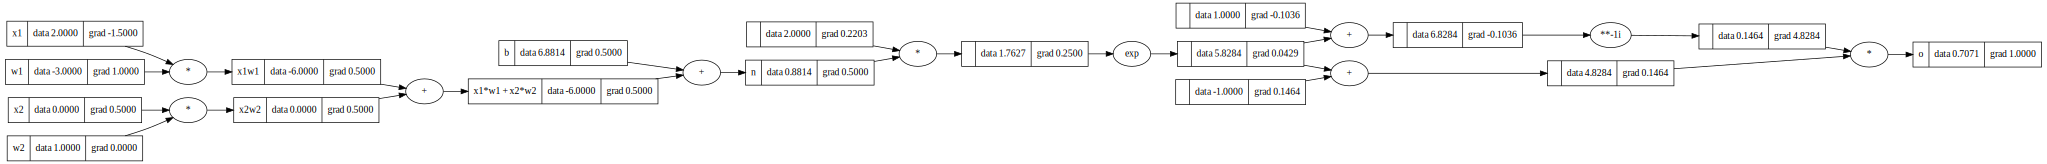

In [16]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# o = n.tanh(); o.label = 'o'
# --------------
e = (2*n).exp()
o = (e - 1)/(e + 1)
# ------------
o.label = 'o'
o.backward()
draw_dot(o)

In [17]:
# stopped at 1:39:42 
# pytorch next

In [18]:
import torch

In [19]:
a = torch.tensor([[1,2,3], [4,5,6]])
print(a)
print(a.shape)
print(type(a))
print(a.dtype)
b = torch.Tensor([[1,2,3], [4,5,6]])
print(b)
print(b.shape)
print(type(b))
print(b.dtype)

tensor([[1, 2, 3],
        [4, 5, 6]])
torch.Size([2, 3])
<class 'torch.Tensor'>
torch.int64
tensor([[1., 2., 3.],
        [4., 5., 6.]])
torch.Size([2, 3])
<class 'torch.Tensor'>
torch.float32


In [20]:
# cast to double() (float64) to be consistent with python's default
# otherwise torch.Tensor creates float32s
#
# because these are leaf nodes, pytorch thinks they do not require
# gradients, so you have to let pytorch know that we want to calc them
#
x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; x1.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [21]:
print(b)
print(b.shape)
print(type(b))
print(b.dtype)

tensor([6.8814], dtype=torch.float64)
torch.Size([1])
<class 'torch.Tensor'>
torch.float64


In [22]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [23]:
o.item()

0.7071066904050358

In [24]:
o.data

tensor([0.7071], dtype=torch.float64)

In [25]:
o.data.item()

0.7071066904050358

In [26]:
# same same

In [211]:
import random
class Neuron:
    
    def __init__(self, nin): # nin = number of inputs
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # return 1 if only 1
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
    
class MLP:
    
    def __init__(self, nin, nouts): # nouts is a list
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    


In [213]:
len(mlp.parameters())

41

In [ ]:
    
    
x = [2.0, 3.0, -1]
# n = Neuron(2)
# n(x)
# l = Layer(2, 3)
# l(x)

mlp = MLP(3, [4,4,1])
mlp(x)


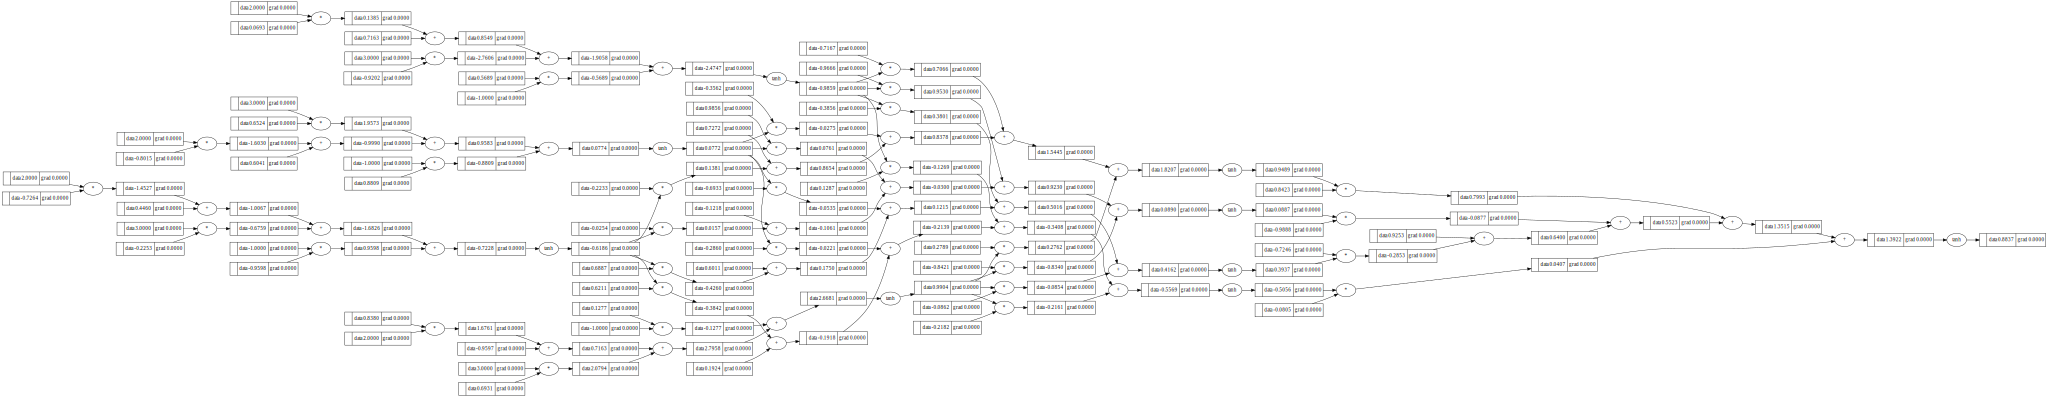

In [187]:
draw_dot(mlp(x))

In [217]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [mlp(x) for x in xs]
ypred

[Value(data=-0.3696868058359028),
 Value(data=0.8711151985084136),
 Value(data=-0.3668244954938136),
 Value(data=-0.22194893342722988)]

In [218]:
def mse(gts, preds):
    loss = 0.0
    for gt, pred in zip(gts, preds):
        loss += (gt - pred)**2
    return loss/len(gts)
        
loss = mse(ys, ypred)
print("mse:", loss)

def se(gts, preds):
    return sum([(gt - pred)**2 for gt,pred in zip(gts,preds)])

loss = se(ys, ypred)
print("se:", loss)

[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

mse: Value(data=1.8177961118951866)
se: Value(data=7.271184447580747)


[Value(data=1.8760419460809583),
 Value(data=3.50107208608918),
 Value(data=0.4009112195066637),
 Value(data=1.493159195903945)]

In [219]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=7.271184447580747)

In [230]:
loss.backward()
loss

Value(data=6.291155575550112)

In [231]:

ypred = [mlp(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=6.291155575550112)

In [223]:
mlp.layers[0].neurons[0].w[0].grad

-0.2297402822977055

In [224]:
mlp.layers[0].neurons[0].w[0].data

0.12881465993687313

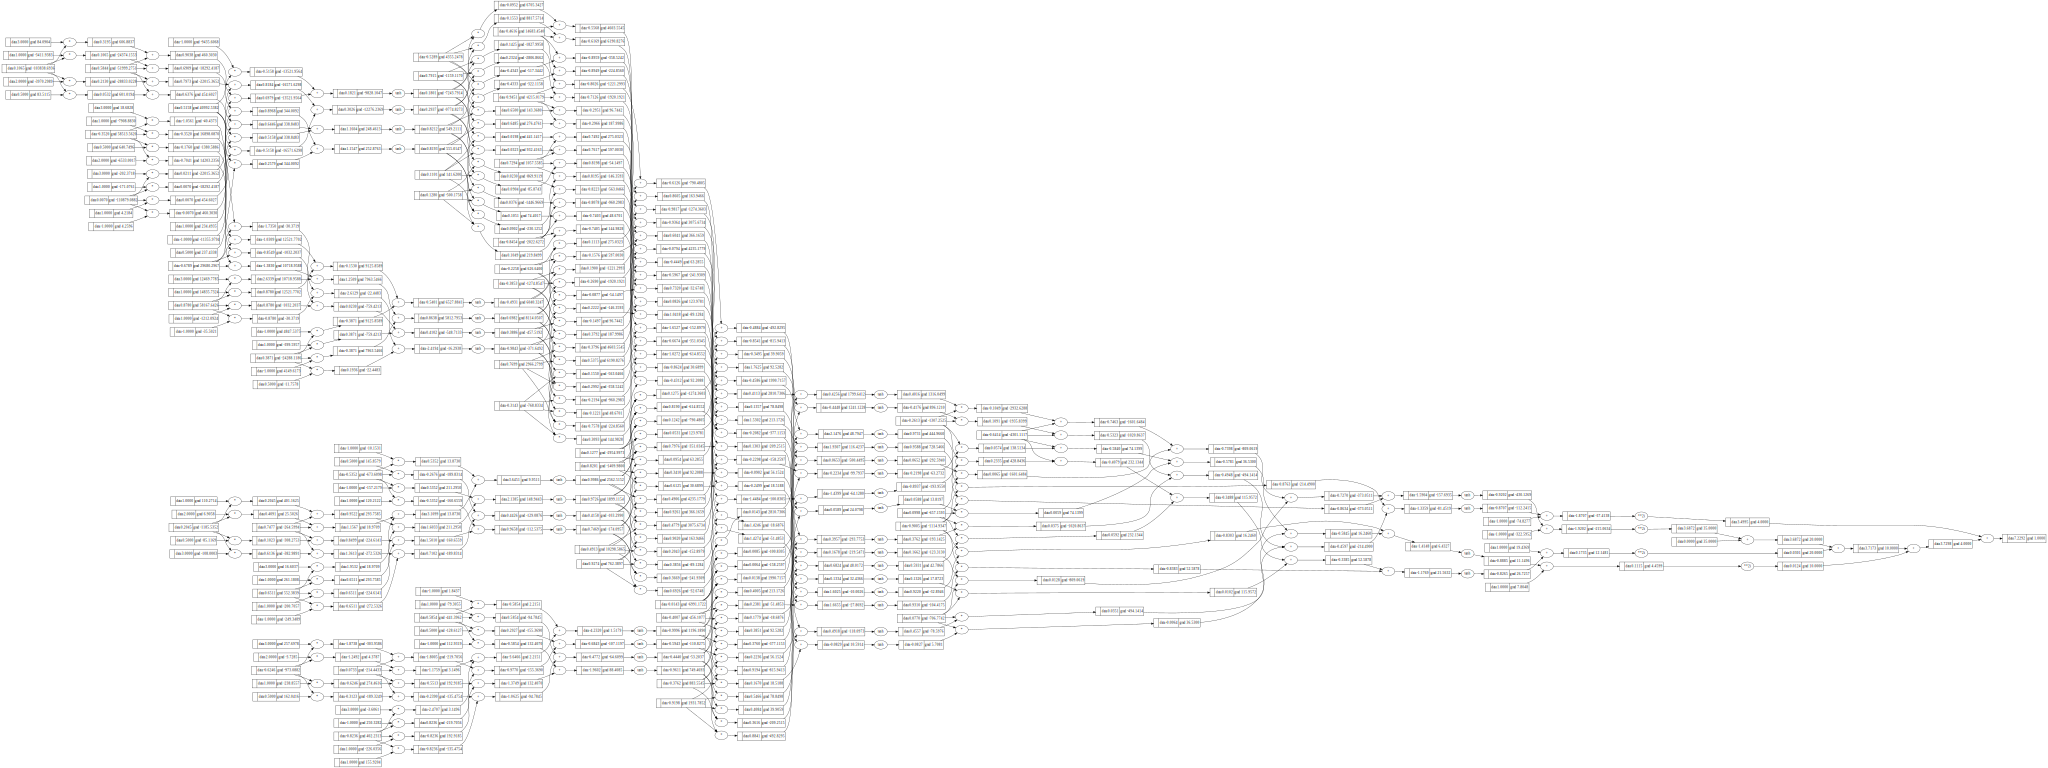

In [185]:
draw_dot(loss)

In [208]:
[x for y in a for x in b]

[6,
 7,
 8,
 9,
 6,
 7,
 8,
 9,
 6,
 7,
 8,
 9,
 6,
 7,
 8,
 9,
 6,
 7,
 8,
 9,
 6,
 7,
 8,
 9,
 6,
 7,
 8,
 9,
 6,
 7,
 8,
 9,
 6,
 7,
 8,
 9,
 6,
 7,
 8,
 9]

In [232]:
for p in mlp.parameters():
    p.data += -0.01 * p.grad

In [227]:
mlp.parameters()

[Value(data=0.13111206275985018),
 Value(data=0.10864787087352243),
 Value(data=0.6419752361859977),
 Value(data=-0.20280593700326868),
 Value(data=-0.16050521870163872),
 Value(data=0.7346607575575219),
 Value(data=-0.822474045894924),
 Value(data=0.5166563591730754),
 Value(data=-0.12327458970907429),
 Value(data=0.43325685039136014),
 Value(data=-0.5133004524641906),
 Value(data=0.3951179657986112),
 Value(data=0.29107709595556913),
 Value(data=-0.2824874829374925),
 Value(data=0.924786121034134),
 Value(data=-0.20437312390581555),
 Value(data=0.7133273786019443),
 Value(data=0.5740692456676524),
 Value(data=0.2752454706982454),
 Value(data=0.039662769161746145),
 Value(data=0.10215835725813043),
 Value(data=0.9961504552486479),
 Value(data=0.9785164875051766),
 Value(data=0.9438145740899099),
 Value(data=-0.6905598866200862),
 Value(data=0.6302111472823902),
 Value(data=-0.5160575753735139),
 Value(data=-0.5511824907550389),
 Value(data=0.6953443685684294),
 Value(data=0.0936673833

In [233]:

mlp.layers[0].neurons[0].w[0].data

0.1394665880852437

In [300]:
print(loss)
ypred = [mlp(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss.backward()
for p in mlp.parameters():
    p.data += -0.1 * p.grad
print(loss)

Value(data=1.572316572381107e-12)
Value(data=9.375004398296817e-12)


In [301]:
ypred

[Value(data=0.9999978278409767),
 Value(data=-0.9999999999999996),
 Value(data=-0.9999999999993928),
 Value(data=0.9999978420543159)]

In [302]:
loss

Value(data=9.375004398296817e-12)

In [317]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

mlp = MLP(3, [4,4,1])

In [404]:
for i in range(20):
    # forward pass
    ypred = [mlp(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    # backward pass (don't forget to zero-grads)
    for p in mlp.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in mlp.parameters():
        p.data += -0.1 * p.grad
    
    print(i, loss)   

0 Value(data=0.00035526265318095926)
1 Value(data=0.00035493807632037874)
2 Value(data=0.000354614078637323)
3 Value(data=0.0003542906585975227)
4 Value(data=0.0003539678146721041)
5 Value(data=0.0003536455453375488)
6 Value(data=0.0003533238490756777)
7 Value(data=0.00035300272437362303)
8 Value(data=0.00035268216972382624)
9 Value(data=0.00035236218362397215)
10 Value(data=0.00035204276457700463)
11 Value(data=0.0003517239110911066)
12 Value(data=0.0003514056216796212)
13 Value(data=0.0003510878948611167)
14 Value(data=0.0003507707291592802)
15 Value(data=0.00035045412310295376)
16 Value(data=0.00035013807522607727)
17 Value(data=0.0003498225840676878)
18 Value(data=0.00034950764817189115)
19 Value(data=0.00034919326608782997)


In [405]:
ypred

[Value(data=0.9920341175263114),
 Value(data=-0.9881952142829326),
 Value(data=-0.9927520457065165),
 Value(data=0.9903122667647738)]

In [406]:
a = 0
a * 4

0

In [407]:
(a > 0) * 4

0

In [408]:
a = .1
(a > 0) * 4

4